В данном ноутбуке проводится исследование зависимости точности от количества просмотров на видео(отрезаем те что имеют меньше заданного) и от количества просмотров у пользователя(отрезаем те, что имеют меньше заданного)

In [1]:
import tensorflow as tf

# Get the GPU device name.
device_name = tf.test.gpu_device_name()

# The device name should look like the following:
if device_name == '/device:GPU:0':
    print('Found GPU at: {}'.format(device_name))
else:
    raise SystemError('GPU device not found')

import torch

# If there's a GPU available...
if torch.cuda.is_available():

    # Tell PyTorch to use the GPU.
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

Found GPU at: /device:GPU:0
There are 1 GPU(s) available.
We will use the GPU: NVIDIA GeForce RTX 4080 Laptop GPU


In [2]:
# Работа с массивами данных
import numpy as np

import tensorflow

# Функции-утилиты для работы с категориальными данными
from tensorflow.keras import utils

# Класс для конструирования последовательной модели нейронной сети
from tensorflow.keras.models import Sequential

# Основные слои
from tensorflow.keras.layers import Dense, Dropout, SpatialDropout1D, BatchNormalization, Embedding, Flatten, Activation
from tensorflow.keras.layers import SimpleRNN, GRU, LSTM, Bidirectional, Conv1D, MaxPooling1D, GlobalMaxPooling1D

# Токенизатор для преобразование текстов в последовательности
from tensorflow.keras.preprocessing.text import Tokenizer

# Рисование схемы модели
from tensorflow.keras.utils import plot_model

# Матрица ошибок классификатора
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Загрузка датасетов из облака google
import gdown

# Функции операционной системы
import os

# Работа со временем
import time

# Регулярные выражения
import re

# Отрисовка графиков
import matplotlib.pyplot as plt

# Вывод объектов в ячейке colab
from IPython.display import display

import pandas as pd

%matplotlib inline

In [4]:
def dell_vid(data, number_of_views):
    ddd = data['rutube_video_id'].value_counts().index.tolist() 
    vc = data['rutube_video_id'].value_counts()
    ee = []
    for i in ddd:
        if vc[i] > number_of_views:
            ee.append(i)
    data = data[data['rutube_video_id'].isin(ee)]
    return data



In [45]:
def dataset_for_hand_maid(data_path, video_path, target_path, count_views_on_video):
    
    data = pd.read_csv('train_events.csv')
    video = pd.read_csv( 'video_info_v2.csv')
    targets = pd.read_csv( 'train_targets.csv')

    #Удаление видео у которых мало просмотров
    data = dell_vid(data, count_views_on_video)

    #Создание временного ряда видео
    unique_values = data['rutube_video_id'].unique()
    mapping = {value: i for i, value in enumerate(unique_values)}
    df = data[['viewer_uid','rutube_video_id']]
    df['rutube_video_id'] = df['rutube_video_id'].map(mapping)

    #добавляем таргеты
    df_grouped = df.groupby('viewer_uid')['rutube_video_id'].apply(list).reset_index(name='videos')
    merg = pd.merge(targets[['viewer_uid','age_class','sex']],df_grouped, on='viewer_uid')

    
    merg.loc[merg['sex']=='male','sex'] = 1
    merg.loc[merg['sex']=='female','sex'] = 0

    # не принесли прирост в точности 
    """
    #достаем инфу о категориях которые смотрит пользователь
    usr_vid = data.merge(video, on='rutube_video_id')
    usr_cat = usr_vid[['viewer_uid','category']]
    usr_cat = pd.get_dummies(usr_cat, columns=['category'])
    usr_cat = usr_cat.groupby('viewer_uid').sum()
    all_cat = list(usr_cat.columns)
    usr_cat = usr_cat.reset_index()
    merg = pd.merge(merg,usr_cat, on='viewer_uid')

    #достаем инфу о устройстве пользователя
    usr_dev = data[['viewer_uid','ua_device_type']]
    usr_dev = pd.get_dummies(usr_dev, columns=['ua_device_type'])
    usr_dev = usr_dev.groupby('viewer_uid').sum()
    usr_dev = usr_dev.reset_index()
    merg = pd.merge(merg,usr_dev, on='viewer_uid')

    #достаем инфу о опеационке пользователя
    usr_os = data[['viewer_uid','ua_os']]
    usr_os = pd.get_dummies(usr_os, columns=['ua_os'])
    usr_os = usr_os.groupby('viewer_uid').sum()
    usr_os = usr_os.reset_index()
    merg = pd.merge(merg,usr_os, on='viewer_uid')
"""

    return merg, unique_values #unique_values понадобятся потом для тестового набора данных 
merg , unique_values= dataset_for_hand_maid('train_events.csv', 'video_info_v2.csv', 'train_targets.csv',count_views_on_video = 10)
merg

C:\Users\oklad\AppData\Local\Temp\ipykernel_2836\902103438.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['rutube_video_id'] = df['rutube_video_id'].map(mapping)


,viewer_uid,age_class,sex,videos
0,10087154,1,1,"[17027, 17027]"
1,10908708,1,0,"[14485, 15366]"
2,10190464,2,1,"[500, 336, 15489, 15277, 16099, 15789]"
3,10288257,3,1,"[178, 17233]"
4,10736308,1,0,"[17073, 16947]"
...,...,...,...,...
166904,10237402,3,0,"[11788, 15916, 16739, 17344]"
166905,10796936,2,1,"[4830, 4878, 3969, 4965, 4972, 5182, 3433, 537..."
166906,10684284,1,1,"[15587, 15615, 15635, 15646, 16255, 17339, 17182]"
166907,10031093,3,0,"[15340, 1869]"


In [41]:
def Sex_data(merg):
    Count_tokens = 64
    
    YS = merg['sex'].to_list()
    X = merg['videos'].to_list()
    
    for i in range(len(X)):
      a = [0 for i in range(Count_tokens)]
      for j in range(len(X[i])):
        if j == Count_tokens:
            break
        a[j] = X[i][j]
      X[i] = a

    from sklearn.model_selection import train_test_split

    labels_train = YS
    
    for i in range(len(labels_train)):
      a = [0 for i in range(2)]
      a[labels_train[i]]=1
      labels_train[i] = a
    
    for i in range(len(labels_train)):
      labels_train[i] = np.array(labels_train[i])
    labels_train = np.array(labels_train)
    
    
    for i in range(len(X)):
      X[i] = np.array(X[i])
    X = np.array(X).astype('int32')
    
    
    X = np.concatenate((X,np.array(merg[merg.columns[4:]])),axis=1).astype('int32')
    x_train, x_test, y_train, y_test = train_test_split(X, labels_train, shuffle=True, random_state=42)


    print(x_train.shape, y_train.shape)
    print(x_test.shape, y_test.shape)
    return x_train, x_test, y_train, y_test
    
    


In [42]:
CLASS_LIST = [0,1]
CLASS_COUNT = len(CLASS_LIST)
VOCAB_SIZE = len(unique_values)
WIN_SIZE = 64

# Функция компиляции и обучения модели нейронной сети
def compile_train_model(model,
                        x_train,
                        y_train,
                        x_val,
                        y_val,
                        optimizer='adam',
                        epochs=50,
                        batch_size=128,
                        figsize=(20, 5)):

    # Компиляция модели
    model.compile(optimizer=optimizer,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    # Вывод сводки
    #model.summary()

    # Вывод схемы модели
    #display(plot_model(model, dpi=60, show_shapes=True))

    # Обучение модели с заданными параметрами
    history = model.fit(x_train,
                        y_train,
                        epochs=epochs,
                        batch_size=batch_size,
                        validation_data=(x_val, y_val))

    return max(history.history['val_accuracy'])


# Функция вывода результатов оценки модели на заданных данных



# Совместная функция обучения и оценки модели нейронной сети
def compile_train_eval_model(model,
                             x_train,
                             y_train,
                             x_test,
                             y_test,
                             class_labels=CLASS_LIST,
                             title='',
                             optimizer='adam',
                             epochs=50,
                             batch_size=128,
                             graph_size=(20, 5),
                             cm_size=(10, 10)):

    # Компиляция и обучение модели на заданных параметрах
    # В качестве проверочных используются тестовые данные
    maxi = compile_train_model(model,
                        x_train, y_train,
                        x_test, y_test,
                        optimizer=optimizer,
                        epochs=epochs,
                        batch_size=batch_size,
                        figsize=graph_size)

    # Вывод результатов оценки работы модели на тестовых данных
    return maxi

In [43]:
def model_new():
    from tensorflow.keras import regularizers
    model_Conv_2 = Sequential()
    model_Conv_2.add(Embedding(VOCAB_SIZE, 50, input_length=WIN_SIZE))
    model_Conv_2.add(SpatialDropout1D(0.2))
    model_Conv_2.add(BatchNormalization())
    # Два слоя одномерной свертки Conv1D
    model_Conv_2.add(Conv1D(20, 5, activation='relu', padding='same',kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4)))
    model_Conv_2.add(Conv1D(20, 5, activation='relu', padding='same',kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4)))
    # Слой подвыборки/пулинга с функцией максимума
    model_Conv_2.add(MaxPooling1D(2))
    model_Conv_2.add(Dropout(0.2))
    model_Conv_2.add(BatchNormalization())
    # Слой глобального пулинга с функцией максимума
    model_Conv_2.add(GlobalMaxPooling1D())
    model_Conv_2.add(Dense(20, activation='relu',kernel_regularizer=regularizers.l2(1e-5)))
    model_Conv_2.add(Dropout(0.2))
    model_Conv_2.add(BatchNormalization())
    model_Conv_2.add(Dense(CLASS_COUNT, activation='softmax',kernel_regularizer=regularizers.l2(1e-5)))
    return model_Conv_2

In [48]:
min_views = [1,2,3,4,5,10,20,50]

In [49]:
merg , unique_values= dataset_for_hand_maid('train_events.csv', 'video_info_v2.csv', 'train_targets.csv',count_views_on_video = 10)
merg['len'] = merg['videos'].apply(lambda x: len(x))
max_accuracy_10 = []
zapis_10 = []
for count_views in min_views:
    merg = merg[merg['len']>=count_views]
    zapis_10.append(merg.shape[0])
    x_train, x_test, y_train, y_test  = Sex_data(merg)

    from tensorflow.keras import regularizers
    model_Conv_2 = model_new()
    
    max_accuracy_10.append(compile_train_eval_model(model_Conv_2,
                             x_train, y_train,
                             x_test, y_test,
                             optimizer='rmsprop',
                             epochs=20,
                             batch_size=200,
                             class_labels=CLASS_LIST,
                             title='Conv1D №2'))

C:\Users\oklad\AppData\Local\Temp\ipykernel_2836\902103438.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['rutube_video_id'] = df['rutube_video_id'].map(mapping)


(125181, 65) (125181, 2)
(41728, 65) (41728, 2)
Epoch 1/20
626/626 [==============================] - 4s 6ms/step - loss: 0.6341 - accuracy: 0.6552 - val_loss: 0.6014 - val_accuracy: 0.6828
Epoch 2/20
626/626 [==============================] - 4s 6ms/step - loss: 0.5902 - accuracy: 0.6886 - val_loss: 0.5846 - val_accuracy: 0.6884
Epoch 3/20
626/626 [==============================] - 3s 6ms/step - loss: 0.5830 - accuracy: 0.6913 - val_loss: 0.5833 - val_accuracy: 0.6887
Epoch 4/20
626/626 [==============================] - 4s 6ms/step - loss: 0.5795 - accuracy: 0.6922 - val_loss: 0.5814 - val_accuracy: 0.6887
Epoch 5/20
626/626 [==============================] - 4s 6ms/step - loss: 0.5773 - accuracy: 0.6929 - val_loss: 0.5855 - val_accuracy: 0.6887
Epoch 6/20
626/626 [==============================] - 3s 6ms/step - loss: 0.5763 - accuracy: 0.6933 - val_loss: 0.5840 - val_accuracy: 0.6898
Epoch 7/20
626/626 [==============================] - 4s 6ms/step - loss: 0.5747 - accuracy: 0.6937 

In [50]:
merg , unique_values= dataset_for_hand_maid('train_events.csv', 'video_info_v2.csv', 'train_targets.csv',count_views_on_video = 100)
merg['len'] = merg['videos'].apply(lambda x: len(x))
max_accuracy_100 = []
zapis_100 = []
for count_views in min_views:
    merg = merg[merg['len']>=count_views]
    zapis_100.append(merg.shape[0])
    x_train, x_test, y_train, y_test  = Sex_data(merg)

    from tensorflow.keras import regularizers
    model_Conv_2 = model_new()
    
    max_accuracy_100.append(compile_train_eval_model(model_Conv_2,
                             x_train, y_train,
                             x_test, y_test,
                             optimizer='rmsprop',
                             epochs=20,
                             batch_size=200,
                             class_labels=CLASS_LIST,
                             title='Conv1D №2'))

C:\Users\oklad\AppData\Local\Temp\ipykernel_2836\902103438.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['rutube_video_id'] = df['rutube_video_id'].map(mapping)


(109696, 65) (109696, 2)
(36566, 65) (36566, 2)
Epoch 1/20
549/549 [==============================] - 4s 6ms/step - loss: 0.5809 - accuracy: 0.7138 - val_loss: 0.5441 - val_accuracy: 0.7553
Epoch 2/20
549/549 [==============================] - 3s 6ms/step - loss: 0.5098 - accuracy: 0.7599 - val_loss: 0.5014 - val_accuracy: 0.7601
Epoch 3/20
549/549 [==============================] - 3s 6ms/step - loss: 0.5024 - accuracy: 0.7623 - val_loss: 0.4998 - val_accuracy: 0.7588
Epoch 4/20
549/549 [==============================] - 3s 6ms/step - loss: 0.4969 - accuracy: 0.7638 - val_loss: 0.4999 - val_accuracy: 0.7594
Epoch 5/20
549/549 [==============================] - 3s 6ms/step - loss: 0.4938 - accuracy: 0.7651 - val_loss: 0.4989 - val_accuracy: 0.7603
Epoch 6/20
549/549 [==============================] - 3s 6ms/step - loss: 0.4914 - accuracy: 0.7677 - val_loss: 0.5024 - val_accuracy: 0.7590
Epoch 7/20
549/549 [==============================] - 3s 6ms/step - loss: 0.4878 - accuracy: 0.7701 

In [51]:
merg , unique_values= dataset_for_hand_maid('train_events.csv', 'video_info_v2.csv', 'train_targets.csv',count_views_on_video = 1000)

merg['len'] = merg['videos'].apply(lambda x: len(x))
max_accuracy_1000 = []
zapis_1000 = []

for count_views in min_views:  
    merg = merg[merg['len']>=count_views]
    zapis_1000.append(merg.shape[0])

    x_train, x_test, y_train, y_test  = Sex_data(merg)

    from tensorflow.keras import regularizers
    model_Conv_2 = model_new()
    
    max_accuracy_1000.append(compile_train_eval_model(model_Conv_2,
                             x_train, y_train,
                             x_test, y_test,
                             optimizer='rmsprop',
                             epochs=20,
                             batch_size=200,
                             class_labels=CLASS_LIST,
                             title='Conv1D №2'))

C:\Users\oklad\AppData\Local\Temp\ipykernel_2836\902103438.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['rutube_video_id'] = df['rutube_video_id'].map(mapping)


(72699, 65) (72699, 2)
(24233, 65) (24233, 2)
Epoch 1/20
364/364 [==============================] - 3s 6ms/step - loss: 0.5560 - accuracy: 0.7376 - val_loss: 0.6020 - val_accuracy: 0.6610
Epoch 2/20
364/364 [==============================] - 2s 6ms/step - loss: 0.5043 - accuracy: 0.7705 - val_loss: 0.4981 - val_accuracy: 0.7745
Epoch 3/20
364/364 [==============================] - 2s 6ms/step - loss: 0.4971 - accuracy: 0.7726 - val_loss: 0.4958 - val_accuracy: 0.7744
Epoch 4/20
364/364 [==============================] - 2s 6ms/step - loss: 0.4955 - accuracy: 0.7740 - val_loss: 0.4935 - val_accuracy: 0.7738
Epoch 5/20
364/364 [==============================] - 2s 6ms/step - loss: 0.4933 - accuracy: 0.7744 - val_loss: 0.4938 - val_accuracy: 0.7742
Epoch 6/20
364/364 [==============================] - 2s 6ms/step - loss: 0.4925 - accuracy: 0.7744 - val_loss: 0.4935 - val_accuracy: 0.7734
Epoch 7/20
364/364 [==============================] - 2s 6ms/step - loss: 0.4916 - accuracy: 0.7752 - 

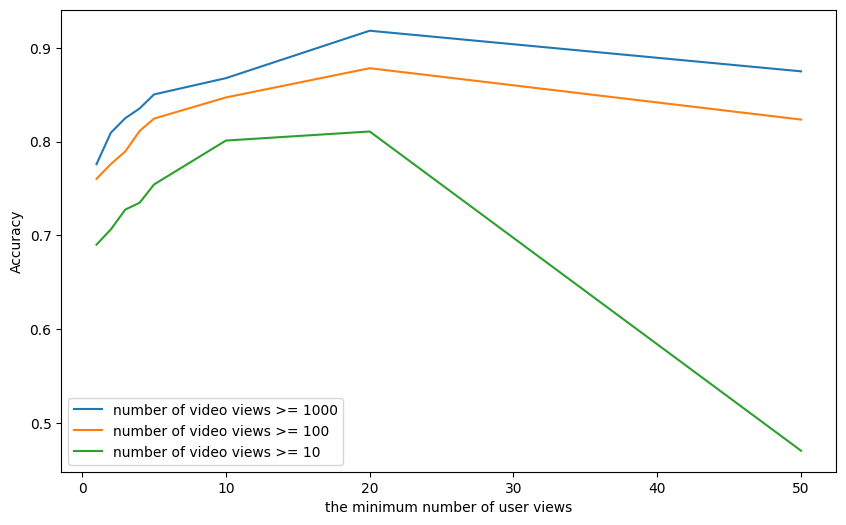

In [65]:
plt.figure(figsize=(10, 6))

plt.plot(min_views, max_accuracy_1000, label="number of video views >= 1000")
plt.plot(min_views, max_accuracy_100, label="number of video views >= 100")
plt.plot(min_views, max_accuracy_10, label="number of video views >= 10")

plt.xlabel("the minimum number of user views")
plt.ylabel("Accuracy")
plt.legend()

plt.show()

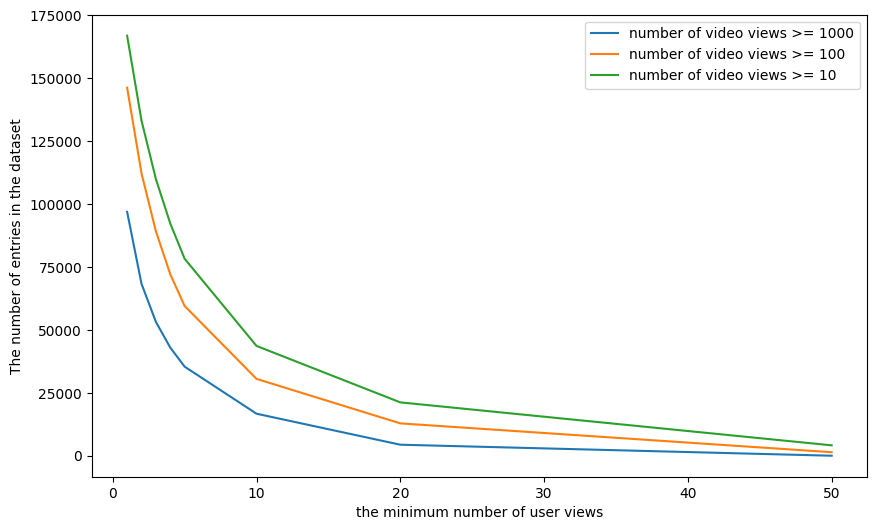

In [66]:
plt.figure(figsize=(10, 6))

plt.plot(min_views, zapis_1000, label="number of video views >= 1000")
plt.plot(min_views, zapis_100, label="number of video views >= 100")
plt.plot(min_views, zapis_10, label="number of video views >= 10")

plt.xlabel("the minimum number of user views")
plt.ylabel("The number of entries in the dataset")
plt.legend()

plt.show()